# Fine-tune SHA-RNN with ULMFiT on IMDB

In [1]:
import os
import torch
from torch import nn
from fastai.text import *
from fastai.callbacks import *

In [2]:
DATA_PATH = os.path.join(".", "sha_rnn")

## LM fine-tuning

Note that we want to take advantage of the attentional layer of SHA-RNN, so we use a larger BPTT value.

In [3]:
bs, bptt = 16, 300

In [4]:
path = untar_data(URLs.IMDB)

In [5]:
with open("/workspace/data/sha_rnn/wt_lm_vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

In [6]:
vocab = Vocab(vocab)

In [ ]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train, test and unsup
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs, bptt=bptt))

In [8]:
data_lm.save('/workspace/data/sha_rnn/data_imdb_lm.pkl')

In [7]:
data_lm = load_data("/workspace/data/sha_rnn/", "data_imdb_lm.pkl")

In [8]:
from sharnn.model import SHARNN

In [9]:
class SHARNNWrapper(nn.Module):
    """
    Making things work without tinkering with code of either project
    """
    def __init__(self, sharnn_params):
        super().__init__()
        self.sharnn = SHARNN(**sharnn_params)
        self.hidden = None
        self.mems = None

    def forward(self, input):
        # the original SHA-RNN is seqlen-first, unlike fastai
        input = input.t()
        h, new_hidden, new_mems, _, _ = self.sharnn(input, hidden=self.hidden, 
                                              mems=self.mems, return_h=True)

        self.hidden = to_detach(new_hidden, cpu=False)
        self.mems = to_detach(new_mems, cpu=False)
        
        # back to batch-first
        output = [h.permute(1, 0, 2)]
        # I don't think something really uses raw_outputs in fastai. These outputs
        # have already went through dropout:
        # https://github.com/Smerity/sha-rnn/blob/218d748022dbcf32d50bbbb4d151a9b6de3f8bba/model.py#L320
        return output, output

In [10]:
# replicating most of the parameters from readme and defaults
params = {
    "rnn_type": "LSTM",
    "ntoken": len(vocab.itos),
    "ninp": 1024,
    "nhid": 4096,
    "nlayers": 4,
    "dropouth": 0.1,
    "dropouti": 0.1,
    "dropout": 0.1,
    "tie_weights": True
}

In [11]:
sharnn = SHARNNWrapper(params)

In [12]:
decoder = LinearDecoder(n_out=len(vocab.itos), n_hid=1024, 
                        tie_encoder=None, output_p=0)

In [13]:
model = SequentialRNN(sharnn, decoder)

In [14]:
learn = LanguageLearner(data_lm, model)

In [15]:
learn.load("/workspace/data/sha_rnn/models/stage2_final")

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (89803 items)
x: LMTextList
xxbos xxmaj frownland is like one of those intensely embarrassing situations where you end up laughing out loud at exactly the wrong time ; and just at the moment you realize you should n't be laughing , you 've already reached the pinnacle of voice xxunk ; and as you look around you at the ghostly white faces with their gaping wide - open mouths and xxunk eyes , you feel a piercing ache beginning in the pit of your stomach and suddenly rushing up your throat and ... well , you get the point . 
 
  xxmaj but for all its unpleasantness and punches in the face , xxmaj frownland , really is a remarkable piece of work that , after viewing the inarticulate mess of a main character and all his pathetic troubles and mishaps , makes you want to scratch your own eyes out and at the same time , you feel xxunk sorry for him . 
 
  xxmaj it would have been a lot easier for me to simply walk out of xxmaj ronald xxma

Now we have to convert the old vocabulary into the new vocabulary as per the ULMFiT procedure. Doesn't work out of the box, so here are a few hacks.

In [16]:
old_stoi = {w: i for i, w in enumerate(vocab.itos)}

In [17]:
wgts_to_convert = {
    "0.encoder.weight": learn.model[0].sharnn.encoder.weight,
    "1.decoder.bias": learn.model[1].decoder.bias
}
converted = convert_weights(wgts_to_convert, old_stoi, data_lm.train_ds.vocab.itos)

In [18]:
converted.keys()

dict_keys(['0.encoder.weight', '1.decoder.bias', '1.decoder.weight'])

In [19]:
state_dict = learn.model.state_dict()
state_dict["0.sharnn.encoder.weight"] = converted["0.encoder.weight"]
state_dict["1.decoder.weight"] = converted["1.decoder.weight"]
state_dict["1.decoder.bias"] = converted["1.decoder.bias"]
learn.model.load_state_dict(state_dict)

<All keys matched successfully>

As blocks are not sequential, fastai built-in param_groups does not work

In [20]:
param_blocks = {
    0: [
    "0.sharnn.blocks.0.ff.linear1.weight",
    "0.sharnn.blocks.0.ff.linear1.bias",
    "0.sharnn.blocks.0.lnstart.weight",
    "0.sharnn.blocks.0.lnstart.bias",
    "0.sharnn.blocks.0.lnmid.weight",
    "0.sharnn.blocks.0.lnmid.bias",
    "0.sharnn.blocks.0.lnmem.weight",
    "0.sharnn.blocks.0.lnmem.bias",
    "0.sharnn.blocks.0.lnout.weight",
    "0.sharnn.blocks.0.lnout.bias",
    "0.sharnn.blocks.0.lnff.weight",
    "0.sharnn.blocks.0.lnff.bias",
    "0.sharnn.blocks.0.lnxff.weight",
    "0.sharnn.blocks.0.lnxff.bias",
    "0.sharnn.blocks.0.rnn.weight_ih_l0",
    "0.sharnn.blocks.0.rnn.weight_hh_l0",
    "0.sharnn.blocks.0.rnn.bias_ih_l0",
    "0.sharnn.blocks.0.rnn.bias_hh_l0",
    ],
    1: [                    
    "0.sharnn.blocks.1.ff.linear1.weight",
    "0.sharnn.blocks.1.ff.linear1.bias",
    "0.sharnn.blocks.1.lnstart.weight",
    "0.sharnn.blocks.1.lnstart.bias",
    "0.sharnn.blocks.1.lnmid.weight",
    "0.sharnn.blocks.1.lnmid.bias",
    "0.sharnn.blocks.1.lnmem.weight",
    "0.sharnn.blocks.1.lnmem.bias",
    "0.sharnn.blocks.1.lnout.weight",
    "0.sharnn.blocks.1.lnout.bias",
    "0.sharnn.blocks.1.lnff.weight",
    "0.sharnn.blocks.1.lnff.bias",
    "0.sharnn.blocks.1.lnxff.weight",
    "0.sharnn.blocks.1.lnxff.bias",
    "0.sharnn.blocks.1.rnn.weight_ih_l0",
    "0.sharnn.blocks.1.rnn.weight_hh_l0",
    "0.sharnn.blocks.1.rnn.bias_ih_l0",
    "0.sharnn.blocks.1.rnn.bias_hh_l0",
    ],
    2: [
    "0.sharnn.blocks.2.attn.qs",
    "0.sharnn.blocks.2.attn.ks",
    "0.sharnn.blocks.2.attn.vs",
    "0.sharnn.blocks.2.attn.qkvs",
    "0.sharnn.blocks.2.attn.r_gate",
    "0.sharnn.blocks.2.attn.q.weight",
    "0.sharnn.blocks.2.attn.q.bias",
    "0.sharnn.blocks.2.attn.qln.weight",
    "0.sharnn.blocks.2.attn.qln.bias",
    "0.sharnn.blocks.2.attn.vq.l1.weight",
    "0.sharnn.blocks.2.attn.vq.l1.bias",
    "0.sharnn.blocks.2.ff.linear1.weight",
    "0.sharnn.blocks.2.ff.linear1.bias",
    "0.sharnn.blocks.2.lnstart.weight",
    "0.sharnn.blocks.2.lnstart.bias",
    "0.sharnn.blocks.2.lnmid.weight",
    "0.sharnn.blocks.2.lnmid.bias",
    "0.sharnn.blocks.2.lnmem.weight",
    "0.sharnn.blocks.2.lnmem.bias",
    "0.sharnn.blocks.2.lnout.weight",
    "0.sharnn.blocks.2.lnout.bias",
    "0.sharnn.blocks.2.lnff.weight",
    "0.sharnn.blocks.2.lnff.bias",
    "0.sharnn.blocks.2.lnxff.weight",
    "0.sharnn.blocks.2.lnxff.bias",
    "0.sharnn.blocks.2.rnn.weight_ih_l0",
    "0.sharnn.blocks.2.rnn.weight_hh_l0",
    "0.sharnn.blocks.2.rnn.bias_ih_l0",
    "0.sharnn.blocks.2.rnn.bias_hh_l0",
    ],
    3: [
    "0.sharnn.blocks.3.ff.linear1.weight",
    "0.sharnn.blocks.3.ff.linear1.bias",
    "0.sharnn.blocks.3.lnstart.weight",
    "0.sharnn.blocks.3.lnstart.bias",
    "0.sharnn.blocks.3.lnmid.weight",
    "0.sharnn.blocks.3.lnmid.bias",
    "0.sharnn.blocks.3.lnmem.weight",
    "0.sharnn.blocks.3.lnmem.bias",
    "0.sharnn.blocks.3.lnout.weight",
    "0.sharnn.blocks.3.lnout.bias",
    "0.sharnn.blocks.3.lnff.weight",
    "0.sharnn.blocks.3.lnff.bias",
    "0.sharnn.blocks.3.lnxff.weight",
    "0.sharnn.blocks.3.lnxff.bias",
    "0.sharnn.blocks.3.rnn.weight_ih_l0",
    "0.sharnn.blocks.3.rnn.weight_hh_l0",
    "0.sharnn.blocks.3.rnn.bias_ih_l0",
    "0.sharnn.blocks.3.rnn.bias_hh_l0",
    "0.sharnn.encoder.weight",
    "0.sharnn.decoder.bias",
    ],
    4: [
    "1.decoder.weight",
    "1.decoder.bias",
    ]
}


Freeze the encoder, list trainable parameters:

In [117]:
for name, p in learn.model.named_parameters():
    if name in param_blocks[4]:
        print(name)
        p.requires_grad = True
    else:
        p.requires_grad = False

1.decoder.weight
1.decoder.bias


Optimizer also should only optimize the parameters that have gradients attached.

In [118]:
learn.opt.opt_func = partial(torch.optim.Adam, 
                             parameters=filter(lambda p: p.requires_grad, learn.model.parameters()))

In [102]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


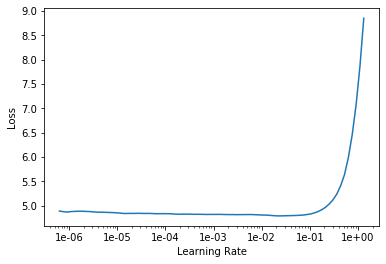

In [103]:
learn.recorder.plot()

Importantly, one-cycle schedule really helped with training. On the other hand, the LR finder did not really help with the LR: 2e-2 is too high, the LM starts to diverge.

In [119]:
learn.fit_one_cycle(1, 3e-4, moms=(0.8, 0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,4.375812,4.195847,0.280373,41:19


In [120]:
learn.save("/workspace/data/sha_rnn/models/ft_stage1")

In [15]:
learn.load("/workspace/data/sha_rnn/models/ft_stage1")

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (89803 items)
x: LMTextList
xxbos xxmaj frownland is like one of those intensely embarrassing situations where you end up laughing out loud at exactly the wrong time ; and just at the moment you realize you should n't be laughing , you 've already reached the pinnacle of voice xxunk ; and as you look around you at the ghostly white faces with their gaping wide - open mouths and xxunk eyes , you feel a piercing ache beginning in the pit of your stomach and suddenly rushing up your throat and ... well , you get the point . 
 
  xxmaj but for all its unpleasantness and punches in the face , xxmaj frownland , really is a remarkable piece of work that , after viewing the inarticulate mess of a main character and all his pathetic troubles and mishaps , makes you want to scratch your own eyes out and at the same time , you feel xxunk sorry for him . 
 
  xxmaj it would have been a lot easier for me to simply walk out of xxmaj ronald xxma

In [50]:
for name, p in learn.model.named_parameters():
    p.requires_grad = True

In [51]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


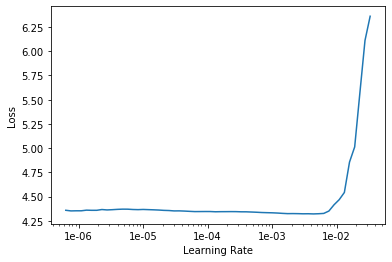

In [52]:
learn.recorder.plot()

In [53]:
learn.fit_one_cycle(5, 1e-4, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,4.137009,3.992794,0.300795,1:42:41
1,4.004018,3.877979,0.313333,1:42:28
2,3.943250,3.825133,0.318933,1:42:19
3,3.893177,3.801575,0.321535,1:42:25
4,3.894965,3.797463,0.322054,1:42:25


In [54]:
learn.save("/workspace/data/sha_rnn/models/ft_stage2")